In [1]:
import importlib
import torch
import torch.nn as nn
from torch.optim import AdamW, Optimizer, SGD
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scratchers.vanilla_transformer.attn import Attention, MultiheadAttention
from scratchers.vanilla_transformer.transformer import TransformerBlock, TransformerDecoder
from scratchers.transformer_config import TransformerConfig
from scratchers.transformer.attn import Attention as CachedAttention
from scratchers.transformer.transformer import TransformerDecoder as CachedTransformerDecoder

In [2]:
import scratchers
importlib.reload(scratchers)

<module 'scratchers' (namespace) from ['/Users/s-a-bakulin/mosquitto/ml/scratchers']>

# Data generation

In [3]:
SOURCE_SEQ_LEN = 12
TARGET_SEQ_LEN = 12

DATA_SIZE = 1500
TRAIN_SIZE = int(DATA_SIZE * 0.8)
TEST_SIZE = DATA_SIZE - TRAIN_SIZE

# radii = np.random.ranf((DATA_SIZE)) # * 9 + 1
radii = np.ones((DATA_SIZE))
starting_radian = np.random.ranf((DATA_SIZE)) * 2 * np.pi
directions = np.random.randint(2, size=DATA_SIZE) * 2 - 1

def to_cartesian(
    radius: float,
    start_radian: float, 
    direction: int
):
    delta = 2 * np.pi / (SOURCE_SEQ_LEN + TARGET_SEQ_LEN)
    seq = np.array([
        np.array([
            radius * np.cos(start_radian + (i * direction * delta)),
            radius * np.sin(start_radian + (i * direction * delta))
        ])
        for i in range(SOURCE_SEQ_LEN + TARGET_SEQ_LEN)
    ])
    source_seq = seq[:-1]
    target_seq = seq[1:]
    return source_seq, target_seq

def make_circles_data():
    X = np.empty((DATA_SIZE, (SOURCE_SEQ_LEN + TARGET_SEQ_LEN) - 1, 2))
    Y = np.empty((DATA_SIZE, (SOURCE_SEQ_LEN + TARGET_SEQ_LEN) - 1, 2))
    for idx, (radius, start_radian, direction) in enumerate(zip(radii, starting_radian, directions)):
        x, y = to_cartesian(radius, start_radian, direction)
        X[idx, :, :] = x
        Y[idx, :, :] = y

    return (
        torch.from_numpy(X[:TRAIN_SIZE]).float(), 
        torch.from_numpy(Y[:TRAIN_SIZE]).float(),
        torch.from_numpy(X[TRAIN_SIZE:]).float(), 
        torch.from_numpy(Y[TRAIN_SIZE:]).float()
    )

def make_squares_data():
    X = np.empty((DATA_SIZE, (2 + 2) - 1, 2))
    Y = np.empty((DATA_SIZE, (2 + 2) - 1, 2))

    def map(elements):
        res = []
        for element in elements:
            if element == 0:
                res.append(np.array([-1, -1]))
            elif element == 1:
                res.append(np.array([1, -1]))
            elif element == 2:
                res.append(np.array([1, 1]))
            elif element == 3:
                res.append(np.array([-1, 1]))

        return np.array(res)

    first = np.random.randint(0, 4, size=(DATA_SIZE))
    second = (first + 1) % 4
    third = (second + 1) % 4
    fourth = (third + 1) % 4
    first = map(first)
    second = map(second)
    third = map(third)
    fourth = map(fourth)

    X[:, 0, :] = first
    X[:, 1, :] = second
    X[:, 2, :] = third
    Y[:, 0, :] = second
    Y[:, 1, :] = third
    Y[:, 2, :] = fourth

    return (
        torch.from_numpy(X[:TRAIN_SIZE]).float(), 
        torch.from_numpy(Y[:TRAIN_SIZE]).float(),
        torch.from_numpy(X[TRAIN_SIZE:]).float(), 
        torch.from_numpy(Y[TRAIN_SIZE:]).float()
    )


X_train, y_train, X_test, y_test = make_circles_data()

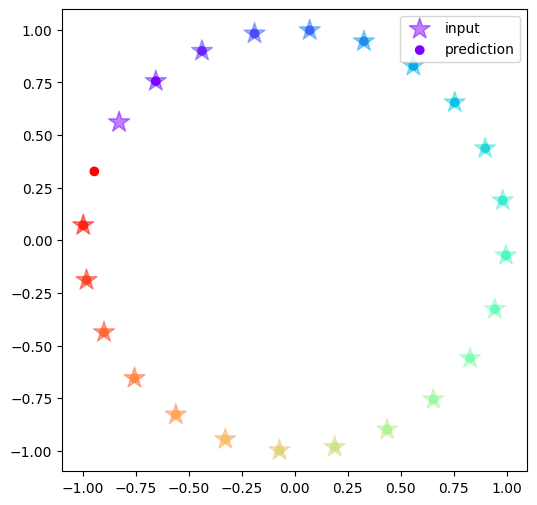

In [4]:
def plot_circle(input, prediction, figsize=(6, 6)):
    plt.figure(figsize=figsize)
    colors = cm.rainbow(np.linspace(0, 1, len(input)))
    plt.scatter(
        input[:, 0], input[:, 1], label="input", marker="*", s=250, alpha=0.5, color=colors
    )
    plt.scatter(prediction[:, 0], prediction[:, 1], label="prediction", color=colors)
    plt.legend()

plot_circle(X_train[4], y_train[4])

# Train

In [5]:
cfg = TransformerConfig(
    input_size=2,
    attn_d_k=32,
    transformer_proj_dim=64,
    dropout=0.2,
    nlayers=2,
    is_self_attn=False,
    max_seq_len=TARGET_SEQ_LEN + SOURCE_SEQ_LEN,
    nheads=2,
    pre_layer_norm=True,
    use_cache=True
)

def attn_factory(config: TransformerConfig):
    return Attention(
        d_k=config.attn_d_k,
        # nheads=config.nheads,
        is_self_attn=config.is_self_attn,
        dropout=config.dropout
    )

def caching_attn_factory(config: TransformerConfig):
    return CachedAttention(
        d_k=config.attn_d_k,
        dropout=config.dropout
    )

In [6]:
class Trainer:
    def __init__(
        self,
        train_data_loader: DataLoader,
        test_data_loader: DataLoader,
        optimizer: Optimizer,
        model: nn.Module,
        lr_scheduler = None,
        epochs: int = 10,
    ):
        self.train_data_loader = train_data_loader
        self.test_data_loader = test_data_loader
        self.optimizer = optimizer
        self.model = model
        self.lr_scheduler = lr_scheduler
        self.epochs = epochs

    def train(self, loss_fn: callable):
        for epoch in range(self.epochs):
            losses = []
            self.model.train()
            for x_batch, y_batch in self.train_data_loader:
                out = self.model(x_batch)
                loss = loss_fn(out, y_batch)
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

                losses.append(loss.detach().cpu().numpy())

            if self.lr_scheduler is not None:
                self.lr_scheduler.step()

            print(f"Train loss at epoch ({epoch}): ", np.array(losses).mean())

            with torch.no_grad():
                self.model.eval()
                test_losses = []
                for x_batch, y_batch in self.test_data_loader:
                    out = self.model(x_batch)
                    loss = loss_fn(out, y_batch)
                    test_losses.append(loss.detach().cpu().numpy())

                print(f"Test loss at epoch ({epoch}): ", np.array(test_losses).mean())

In [7]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

EPOCHS = 1500

train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)
decoder = TransformerDecoder(cfg, attn_factory)
optimizer = SGD(decoder.parameters(), lr=1e-4, momentum=0.9)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)
trainer = Trainer(
    train_data_loader=train_data_loader,
    test_data_loader=test_data_loader,
    # optimizer=AdamW(decoder.parameters(), lr=1e-5),
    optimizer=optimizer,
    model=decoder,
    lr_scheduler=lr_scheduler,
    epochs=EPOCHS
)

# trainer.train(loss_fn=nn.L1Loss())

In [8]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

EPOCHS = 1500

train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)
cached_decoder = CachedTransformerDecoder(cfg)
optimizer = SGD(cached_decoder.parameters(), lr=1e-4, momentum=0.9)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)
trainer = Trainer(
    train_data_loader=train_data_loader,
    test_data_loader=test_data_loader,
    # optimizer=AdamW(decoder.parameters(), lr=1e-5),
    optimizer=optimizer,
    model=cached_decoder,
    lr_scheduler=lr_scheduler,
    epochs=EPOCHS
)

trainer.train(loss_fn=nn.L1Loss())

Train loss at epoch (0):  0.72251946
Test loss at epoch (0):  0.61641324
Train loss at epoch (1):  0.5616314
Test loss at epoch (1):  0.48370397
Train loss at epoch (2):  0.451972
Test loss at epoch (2):  0.38260365
Train loss at epoch (3):  0.37542135
Test loss at epoch (3):  0.31361064
Train loss at epoch (4):  0.32571858
Test loss at epoch (4):  0.27149117
Train loss at epoch (5):  0.29638687
Test loss at epoch (5):  0.24568234
Train loss at epoch (6):  0.2776189
Test loss at epoch (6):  0.22882755
Train loss at epoch (7):  0.26447824
Test loss at epoch (7):  0.21642952
Train loss at epoch (8):  0.2542866
Test loss at epoch (8):  0.20664339
Train loss at epoch (9):  0.24454743
Test loss at epoch (9):  0.19823301
Train loss at epoch (10):  0.23535153
Test loss at epoch (10):  0.19106942
Train loss at epoch (11):  0.22842552
Test loss at epoch (11):  0.18448481
Train loss at epoch (12):  0.22228202
Test loss at epoch (12):  0.17865519
Train loss at epoch (13):  0.21649452
Test loss at

In [17]:
def predict(model, n_tokens, inputs):
    model.eval()
    with torch.no_grad():
        input_len = inputs.size(-2)
        for i in range(n_tokens):
            inputs = torch.cat((inputs, model.predict(inputs)), dim=-2)
        return inputs[:, input_len:, :]

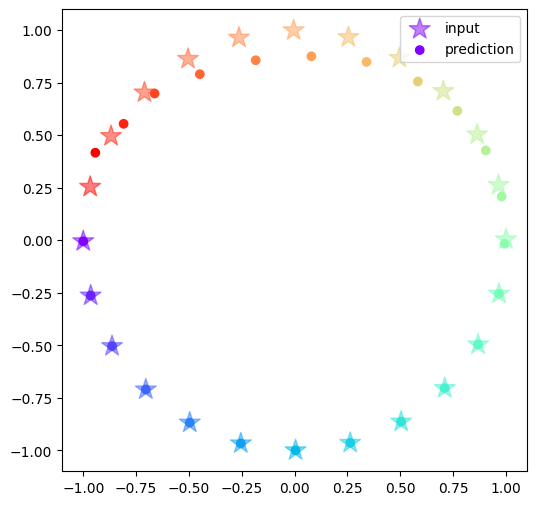

In [15]:
x_sample, y_sample = test_dataset[np.random.randint(0, TEST_SIZE)]
predictions = cached_decoder.predict(x_sample.unsqueeze(0)[:, :SOURCE_SEQ_LEN, :], TARGET_SEQ_LEN)
labels = torch.cat((x_sample, y_sample[-1:]))

plot_circle(
    input=labels.detach().numpy()[0:],
    prediction=torch.cat((labels[0:SOURCE_SEQ_LEN, :], predictions[0])).detach().numpy()[0:],
)

In [12]:
x_sample, y_sample = test_dataset[np.random.randint(0, TEST_SIZE)]
predictions = predict(decoder, TARGET_SEQ_LEN, x_sample.unsqueeze(0)[:, :SOURCE_SEQ_LEN, :])
labels = torch.cat((x_sample, y_sample[-1:]))

plot_circle(
    input=labels.detach().numpy()[0:],
    prediction=torch.cat((labels[0:SOURCE_SEQ_LEN, :], predictions[0])).detach().numpy()[0:],
)

NameError: name 'decoder' is not defined

In [18]:
import time

cached_time = []
with torch.no_grad():
    for i in range(1000):
        s = time.perf_counter()
        x_sample, y_sample = test_dataset[np.random.randint(0, TEST_SIZE)]
        predictions = cached_decoder.predict(x_sample.unsqueeze(0)[:, :SOURCE_SEQ_LEN, :], TARGET_SEQ_LEN)
        cached_time.append(time.perf_counter() - s)

cacheless_time = []
for i in range(1000):
    s = time.perf_counter()
    predictions = predict(decoder, TARGET_SEQ_LEN, x_sample.unsqueeze(0)[:, :SOURCE_SEQ_LEN, :])
    labels = torch.cat((x_sample, y_sample[-1:]))
    cacheless_time.append(time.perf_counter() - s)

print("Cached: ", np.array(cached_time).mean(), np.array(cached_time).std())
print("Cacheless: ", np.array(cacheless_time).mean(), np.array(cacheless_time).std())

Cached:  0.0032138898537959902 0.001621722942688389
Cacheless:  0.003723135533509776 0.0011225037988922212
